# Fairness Sandox Prototype

This rudimentary version of the framework will contain one dataset, one model, one bias mitigation algorithm, and a limited amount of validation metrics. Emphasis will be on modularity and abstraction so as to encourage more features in the future.

### Setup

Please run the code block below to install the necessary packages (if needed).

In [ ]:
%pip install aif360
%pip install fairlearn
%pip install imbalanced-learn
%pip install matplotlib
%pip install numpy
%pip install pandas
%pip install seaborn
%pip install scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, roc_curve, auc
from collections import Counter

import fairlearn
from fairlearn.metrics import *
import aif360

import copy

# Data + EDA

### Dataset Class

In [3]:
class Dataset:
    def __init__(self, short_name = '', path = '', cat_cols = [], num_cols = []):
        self.short_name = short_name
        self.path = path
        self.cat_cols = cat_cols
        self.num_cols = num_cols
        self.df = pd.read_csv(path, sep = ';')

### Popular Datasets

In [4]:
# each dataset is a dictionary where keys = short name, values = Dataset object

datasets = dict()

def add_dataset(dataset):
    if not isinstance(dataset, Dataset):
        print("Error! Please enter a valid Dataset object")
    else:
        if dataset.short_name not in datasets.keys():
            datasets[dataset.short_name] = dataset

In [5]:
# example - adding a dataset
path_adult_income = 'Datasets/adult.csv'
cat_cols = ['workclass', 'education','marital-status', 'occupation', 'relationship', 'race',
            'gender', 'native-country','income']
num_cols = ['age', 'fnlwgt', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
adult_income = Dataset('adult_income', path_adult_income, cat_cols, num_cols)

add_dataset(adult_income)

# TODO - add more datasets

In [6]:
cat = ['school', 'sex', 'address','famsize','Pstatus','Mjob','Fjob','reason',
       'guardian','schoolsup','famsup','paid', 'activities','nursery','higher', 'internet','romantic']
num = ['age', 'Medu', 'Fedu','traveltime','studytime','failures', 'famrel',
       'freetime','goout','Dalc','Walc','health','absences','G1', 'G2', 'G3']

add_dataset(Dataset("student_mat", path='Datasets/student-mat.csv', cat_cols=cat, num_cols=num))
add_dataset(Dataset("student_por", path='Datasets/student-por.csv', cat_cols=cat, num_cols=num))

In [7]:
# (potential) TODO: add functionality for missing data + 
#       encoding categorical features

### EDA

Feel free to use any/all of the following EDA functions and/or add your own!

In [8]:
# take a peek at the first few data points
df_por = datasets['student_por'].df
# df_por.head()

In [9]:
def plot_counts(df, attr):
    if attr in df.columns:
        df[attr].value_counts(normalize=True).plot.barh()
    else:
        print("Error! Please enter a valid feature.")

# example
# plot_counts(df_por, 'sex')

In [10]:
def group_by_plot(df, attr1, attr2):
    for val in list(df[attr1].unique()):
        print(val)
        temp = df[df[attr1] == val]
        sns.displot(temp[attr2])

# example
# group_by_plot(df_por, 'sex', 'G3')

In [11]:
# add support for sns.pairplot, plt.scatter, sns.heatmap

# Preparation

### Problem Formulation

In [12]:
def threshold(df, g_1=0.3, g_2=0.3, g_3=0.4, threshold=11):
    """
    Added "pass/fail" to make problem binary classification
    """
    assert g_1 + g_2 + g_3 == 1, "The sum of the percentages should be 1"
    assert 0 < threshold < 20, "Threshold needs to be between 0 and 20"
    df['pass'] = df.apply(lambda row: 1
                                 if g_1*row['G1'] + g_2*row['G2'] + g_3*row['G3'] >= threshold
                                 else 0, axis=1)
#generate_pnp(datasetMath)
threshold(df_por, threshold=14)
# df_por['pass'].value_counts()

We will now ask you to identify potential sensitive/protected attributes. Run the chunk below to see the different features in the dataset.

In [13]:
# for reference
print(datasets['student_por'].cat_cols)
print(datasets['student_por'].num_cols)

['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob', 'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities', 'nursery', 'higher', 'internet', 'romantic']
['age', 'Medu', 'Fedu', 'traveltime', 'studytime', 'failures', 'famrel', 'freetime', 'goout', 'Dalc', 'Walc', 'health', 'absences', 'G1', 'G2', 'G3']


In [14]:
sens_attrs = [df_por['sex'], df_por['address']]

### Data Preprocessing

In [15]:
# format data
X = df_por.iloc[:, :-2].values
y = df_por.iloc[:, -1].values

In [16]:
# OHE categorical features (prompt for user's choice here?)
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

# get indices of categorical columns
def get_cat_cols(dataset):
    df = dataset.df
    res = []
    for col in dataset.cat_cols:
        res.append(df.columns.get_loc(col))
    return res

cat_cols = get_cat_cols(datasets['student_por'])
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [20]:
X_true = X
y_true = df_por['pass']
#X_bias = copy.deepcopy(X_true)
#y_bias = copy.deepcopy(y_true)

In [ ]:
# TODO - Keep chunk below?

In [ ]:
X_test = df_por.iloc[:, :-2]
X_dum = pd.get_dummies(X_test)
X_dum.columns
type(X)

# Bias Injection

### Class Distribution Visualization

In [21]:
#df_por.shape
df_por['address'].value_counts()

U    452
R    197
Name: address, dtype: int64

In [ ]:
count = pd.value_counts(df_por['address'], sort = True)
count.plot(kind = 'bar', rot = 0)

### Bias Selection

In [ ]:
# TODO - add different biases (over/under sampling, omitted variable, etc)

### Bias Injection

In [22]:
# separate based on protected attribute
sens_values = sens_attrs[1].unique()

# TODO - add prompt for user to specify which value is favored and which is unfavored

df_favored = df_por[df_por['address'] == 'U']
df_unfavored = df_por[df_por['address'] == 'R']

### Under-Sampling Process

In [24]:
# under-sampling process
df_undersampled = df_unfavored.sample(n=190, random_state=42)

#print(df_favored.shape, df_unfavored.shape, df_undersampled.shape)

# combine undersampled and original favored class to create dataset
df_concat = pd.concat([df_favored,df_undersampled])
df_concat.shape

# for fairness measures later
df_sens = df_concat['address']

# format data
X_bias = df_concat.iloc[:, :-2].values
#print(X_undersampled.shape)
y_bias = df_concat.iloc[:, -1].values

# OHE
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), cat_cols)], remainder='passthrough')
X_true_bias = np.array(ct.fit_transform(X_bias))
y_true_bias = df_concat['pass']

print(X_true.shape, X_true_bias.shape)
#print(y_true.value_counts(), "\n\n", y_true_bias.value_counts())

(649, 58) (642, 58)



### Post-Injection Visualization

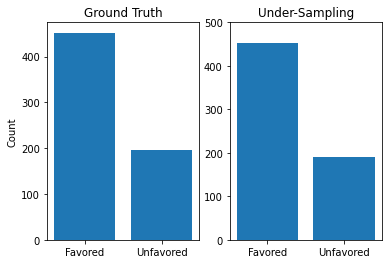

In [35]:
favored = len(df_favored)
true_unfavored = len(df_por[df_por['address'] == 'R'])
bias_unfavored = len(df_undersampled)

x_vals = ['Favored', "Unfavored"]
y_vals_true = [favored, true_unfavored]
y_vals_bias = [favored, bias_unfavored]

plt.subplot(1,2,1)
plt.bar(x_vals, y_vals_true)
plt.title("Ground Truth")
plt.ylabel("Count")

plt.subplot(1,2,2)
plt.bar(x_vals, y_vals_bias)
plt.title("Under-Sampling")
plt.ylim([0,500])

plt.show()

# Model

### Model Selection + Training (TODO: modularize)

In [ ]:
# modularize and add data struct of different ml techniques

from sklearn.metrics import accuracy_score
from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_renn, y_renn)
y_pred_bias = classifier_bias.predict(X_renn)
y_pred_bias_on_true = classifier_bias.predict(X_true)

### Model Performance (TODO: modularize)

In [ ]:
print("Accuracy of Ground Truth Model on Ground Truth Data: ", accuracy_score(y_pred_truth, y_true))
print("Accuracy of Biased Model on Biased Data: ", accuracy_score(y_pred_bias, y_renn))
print("Accuracy of Biased Model on Ground Truth Data: ", accuracy_score(y_pred_bias_on_true, y_true))

Thus, we can see that RENN (under-sampling method) increases model performance on the *biased data* BUT decreases model performance on the ground truth.

In [ ]:
# Ground Truth Model on Ground Truth Data

gm_true = MetricFrame(accuracy_score, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_true.overall)
print("Group Accuracy : ", gm_true.by_group)

print("\n")

sr_true = MetricFrame(selection_rate, y_true, y_pred_truth, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_true.overall)
print("Group Selection Rate : ", sr_true.by_group)

Thus, we can see that there is a **5% discrepancy** in the selection rate for Rural vs Urban students (with Urban students being preferred)

In [ ]:
# Biased Model on Biased Data

gm_bias = MetricFrame(accuracy_score, y_renn, y_pred_bias, sensitive_features = df_addr)
print("Overall Accuracy: ", gm_bias.overall)
print("Group Accuracy : ", gm_bias.by_group)

print("\n")

sr_bias = MetricFrame(selection_rate, y_renn, y_pred_bias, sensitive_features = df_addr)
print("Overall Selection Rate: ", sr_bias.overall)
print("Group Selection Rate : ", sr_bias.by_group)

Thus, we can see that there is now a **10% discrepancy due to RENN** in the selection rate for Rural vs Urban students (with Urban students being preferred) on biased data

In [ ]:
# Biased Model on Ground Truth Data

gm_bias_on_true = MetricFrame(accuracy_score, y_true,
                           y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_bias_on_true.overall)
print("Group Accuracy : ", gm_bias_on_true.by_group)

print("\n")

sr_bias_on_true = MetricFrame(selection_rate, y_true,
                              y_pred_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_bias_on_true.overall)
print("Group Selection Rate : ", sr_bias_on_true.by_group)

Thus, we see that the biased model has lower overall and subgroup accuracy on the ground truth data. 
Also, we can observe that the selection rate disparity increased ever so slightly with the biased model.

In [ ]:
print("Ground Truth Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_truth, sensitive_features=sens_attrs[1]))

print("\n")

print("Biased Model on Ground Truth Data")

print("EOD:", equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPD:", demographic_parity_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

print("EOR:", equalized_odds_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))
print("DPR:", demographic_parity_ratio(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1]))

### Fairness Visualization (Keep this?)

In [ ]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['sex'],
                   sensitive_feature_names = ['sex'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred_truth})

In [ ]:
from fairlearn.widget import FairlearnDashboard
FairlearnDashboard(sensitive_features = df_por['address'],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred_bias_on_true})

# Fairness Intervention

In [ ]:
from fairlearn.reductions import ExponentiatedGradient, DemographicParity
np.random.seed(0)

In [ ]:
constraint = DemographicParity()
mitigator_true = ExponentiatedGradient(classifier_true, constraint)
mitigator_true.fit(X_true, y_true, sensitive_features = sens_attrs[1])
y_pred_mitigated_true = mitigator_true.predict(X_true)

In [ ]:
constraint = DemographicParity()
mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
mitigator_bias.fit(X_renn, y_renn, sensitive_features = df_addr)
y_pred_mitigated_bias = mitigator_bias.predict(X_renn)
y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)

# Evaluation

In [ ]:
# TODO: create data structure of different ml performance metrics
#       get user input and modularize output shown

In [ ]:
print("Accuracy of Ground Truth Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_true, y_true))

print("Accuracy of Biased Model + Fairness Intervention on Ground Truth Data: ",
      accuracy_score(y_pred_mitigated_bias_on_true, y_true))

In [ ]:
# Ground Truth Model + Fairness Intervention on Ground Truth Data

gm_mitigated = MetricFrame(accuracy_score, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated.overall)
print("Group Accuracy : ", gm_mitigated.by_group)

print("\n")

sr_mitigated = MetricFrame(selection_rate, y_true, y_pred_mitigated_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated.overall)
print("Group Selection Rate : ", sr_mitigated.by_group)

In [ ]:
# Biased Model + Fairness Intervention on Ground Truth Data

gm_mitigated_bias_on_true = MetricFrame(accuracy_score, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Accuracy: ", gm_mitigated_bias_on_true.overall)
print("Group Accuracy : ", gm_mitigated_bias_on_true.by_group)

print("\n")

sr_mitigated_bias_on_true = MetricFrame(selection_rate, y_true, y_pred_mitigated_bias_on_true, sensitive_features = sens_attrs[1])
print("Overall Selection Rate: ", sr_mitigated_bias_on_true.overall)
print("Group Selection Rate : ", sr_mitigated_bias_on_true.by_group)

Hence, we observe a decrease in overall and subgroup accuracy, but an **increase in disadvantaged subgroup selection rate**.

In [ ]:
FairlearnDashboard(sensitive_features = sens_attrs[1],
                   sensitive_feature_names = ['address'],
                   y_true = y_true,
                   y_pred = {"initial model" : y_pred_truth, "mitigated model": y_pred_mitigated_true})

### Bias vs Accuracy Trade-Off

In [ ]:
# Under-Sampling with Repeated Edited Nearest Neighbours

renn = RepeatedEditedNearestNeighbours(sampling_strategy="majority", max_iter=3, n_neighbors=3)
X_renn, y_renn = renn.fit_resample(X_true, y_true)

print("Under-Sampling with Repeated Edited Nearest Neighbors\n")
print('Ground Truth Label Distribution: {}'.format(Counter(y_true)))
print('Biased Data Label Distribution: {}'.format(Counter(y_renn)))


classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

classifier_bias = classifier.fit(X_renn, y_renn)
y_pred_bias_on_true = classifier_bias.predict(X_true)

#accuracy_score(y_pred=y_pred_truth, y_true=y_true)
#accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)

In [ ]:
# array of sensitive attribute values for data retained after sampling process

def get_df_sens(X_renn):
    # find indices of data points retained after under-sampling in original dataset
    arr_renn = []
    for i in range(X_renn.shape[0]):
        val = np.where(np.all(X_true == X_renn[i], axis = 1))[0][0]
        arr_renn.append(val)

    #len(arr_renn)

    # find values of sensitive attriubtes for data points retained after under-sampling in original dataset
    sens_attrs_bias = []
    for index in arr_renn:
        val = df_por['address'][index]
        sens_attrs_bias.append(val)

    #len(sens_attrs_bias)

    df_sens = pd.DataFrame(sens_attrs_bias, columns=["address"])
    return df_sens

In [ ]:
bias_amts = list(range(92))
accuracy_on_true = []
accuracy_on_biased = []
eod_on_true = []
eod_on_biased = []
dataset_size_true = np.full(shape=92, fill_value= X_true.shape[0]).tolist()
dataset_size_bias = []
table = []

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

for bias_level in bias_amts:
    # bias injection
    renn = RepeatedEditedNearestNeighbours(sampling_strategy="majority", max_iter=3, n_neighbors=bias_level)
    X_renn, y_renn = renn.fit_resample(X_true, y_true)
    dataset_size_bias.append(X_renn.shape[0])
    
    df_sens = get_df_sens(X_renn)
    
    # model training
    classifier_bias = classifier.fit(X_renn, y_renn)
    y_pred_bias = classifier_bias.predict(X_renn)
    y_pred_bias_on_true = classifier_bias.predict(X_true)
    
    # model performance
    acc_bias = accuracy_score(y_pred=y_pred_bias, y_true=y_renn)
    accuracy_on_biased.append(acc_bias)
    
    acc_bias_on_true = accuracy_score(y_pred=y_pred_bias_on_true, y_true=y_true)
    accuracy_on_true.append(acc_bias_on_true)
    
    # fairness performance
    eod_true = equalized_odds_difference(y_true=y_renn, y_pred = y_pred_bias, sensitive_features=df_sens)
    eod_on_true.append(eod_true)
    
    eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_bias_on_true, sensitive_features=sens_attrs[1])
    eod_on_biased.append(eod_bias_on_true)
    
    # table visualization 
    table_elem = [bias_level, acc_bias, acc_bias_on_true]
    table.append(table_elem)
    
    # print("Finished Iteration: ", bias_level)
    
plt.figure(figsize=(17,7))

plt.subplot(1,2,1)
plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Dataset Size")
plt.legend()

plt.show()
    

In [ ]:
plt.plot(bias_amts, eod_on_true, label = 'Ground Truth')
plt.plot(bias_amts, eod_on_biased, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Equalized Odds Difference")
plt.legend()
plt.show()
#plt.savefig("bias1.png")

In [ ]:
fig, ax = plt.subplots()

fig.patch.set_visible(False)
ax.axis('off')

df_table = pd.DataFrame(table, columns = ['Bias Level', 'Biased Data Accuracy', "Ground Truth Accuracy"])

table_disp = ax.table(cellText=df_table.values, colLabels=df_table.columns, loc = 'center')
table_disp.set_fontsize(13)
table_disp.scale(1,3)

fig.tight_layout()
plt.show()

In [ ]:
bias_amts = list(range(92)) # amount before minority class becomes majority class after under-sampling
accuracy_on_true = []
accuracy_on_biased = []
eod_on_true = []
eod_on_biased = []
dataset_size_true = np.full(shape=92, fill_value= X_true.shape[0]).tolist()
dataset_size_bias = []
table = []

classifier = DecisionTreeClassifier(min_samples_leaf = 10, max_depth = 4)

classifier_true = classifier.fit(X_true, y_true)
y_pred_truth = classifier_true.predict(X_true)

for bias_level in bias_amts:
    # bias injection
    renn = RepeatedEditedNearestNeighbours(sampling_strategy="majority", max_iter=3, n_neighbors=bias_level)
    X_renn, y_renn = renn.fit_resample(X_true, y_true)
    dataset_size_bias.append(X_renn.shape[0])
    
    # fair model training
    df_sens = get_df_sens(X_renn)
    constraint = DemographicParity()
    mitigator_bias = ExponentiatedGradient(classifier_bias, constraint)
    mitigator_bias.fit(X_renn, y_renn, sensitive_features = df_sens)
    y_pred_mitigated_bias = classifier_bias.predict(X_renn)
    y_pred_mitigated_bias_on_true = mitigator_bias.predict(X_true)
    
    # model performance
    acc_bias = accuracy_score(y_pred=y_pred_mitigated_bias, y_true=y_renn)
    accuracy_on_biased.append(acc_bias)
    
    acc_bias_on_true = accuracy_score(y_pred=y_pred_mitigated_bias_on_true, y_true=y_true)
    accuracy_on_true.append(acc_bias_on_true)
    
    # fairness performance
    eod_true = equalized_odds_difference(y_true=y_renn, y_pred = y_pred_mitigated_bias, sensitive_features=df_sens)
    eod_on_true.append(eod_true)
    
    eod_bias_on_true = equalized_odds_difference(y_true=y_true, y_pred = y_pred_mitigated_bias_on_true,
                                                 sensitive_features=sens_attrs[1])
    eod_on_biased.append(eod_bias_on_true)
    
    table_elem = [bias_level, acc_bias, acc_bias_on_true]
    table.append(table_elem)
    
    # print("Finished Iteration: ", bias_level)
    
plt.figure(figsize=(17,7))
plt.subplot(1,2,1)
plt.plot(bias_amts, accuracy_on_true, label = 'Ground Truth')
plt.plot(bias_amts, accuracy_on_biased, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(bias_amts, dataset_size_true, label = 'Ground Truth')
plt.plot(bias_amts, dataset_size_bias, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Dataset Size")
plt.legend()

plt.show()

In [ ]:
plt.plot(bias_amts, eod_on_true, label = 'Ground Truth')
plt.plot(bias_amts, eod_on_biased, label = 'Biased Data')
plt.xlabel("Amount of Bias (n_neighbors value)")
plt.ylabel("Equalized Odds Difference")
plt.legend()
plt.show()
#plt.savefig("bias.png")